In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۸: چندهمخطی و سیگنال‌های مخدوش‌کننده (تشخیص و کاهش اثر)

این درس روی دو مسئله تمرکز می‌کند که اغلب تفسیرپذیری را می‌شکنند و روایت EDA را گمراه می‌کنند:

- **چندهمخطی**: پیش‌بین‌ها اطلاعات هم‌پوشان دارند و ضرایب ناپایدار می‌شوند.
- **سیگنال مخدوش‌کننده**: رابطهٔ ظاهری تا حدی یا کامل توسط متغیر سوم ساخته می‌شود.

در ادامه هر دو مسئله را تشخیص می‌دهید و راهبردهای کاهش اثر را با چند دیتاست از مخزن تمرین می‌کنید.


## ۱) چندهمخطی در فرمول‌ها و هندسه

برای رگرسیون خطی،

$$
y = X\beta + \varepsilon, \qquad \varepsilon \sim (0, \sigma^2 I)
$$

برآوردگر OLS برابر است با

$$
\hat\beta = (X^T X)^{-1} X^T y
$$

و

$$
\mathrm{Var}(\hat\beta) = \sigma^2 (X^T X)^{-1}.
$$

وقتی پیش‌بین‌ها به‌شدت همبسته باشند، $X^T X$ بدشرط می‌شود و وارون آن نویز را بزرگ‌نمایی می‌کند. در بیان SVD، مقدارهای تکین کوچک متناظر با جهت‌های تقریباً افزونه در فضای ویژگی هستند و OLS در آن جهت‌ها شکننده می‌شود.


## ۲) مخدوش‌کنندگی: چرا EDA تجمیعی می‌تواند غلط باشد؟

مخدوش‌کنندگی یک الگوی ساختاری است: متغیر $Z$ هم روی مواجهه $T$ و هم روی خروجی $Y$ اثر می‌گذارد و یک ارتباط گمراه‌کننده بین $T$ و $Y$ می‌سازد. نشانهٔ معروف آن پارادوکس سیمپسون است—روند در دادهٔ تجمیع‌شده با روند درون‌گروهی متفاوت است.

در ML، مخدوش‌کنندگی می‌تواند عملکرد ظاهراً خوب ایجاد کند اما استحکام، تفسیرپذیری و انصاف را تضعیف کند (اثرات پروکسی).


## ۳) نمای کلی کاهش اثر

راهبرد را بر اساس هدف انتخاب کنید:

- اگر **تفسیر** مهم است: افزونگی را کم کنید، یک ویژگی نماینده نگه دارید، جملات مهندسی‌شده را مرکزسازی کنید و پایداری را گزارش دهید.
- اگر **پیش‌بینی** مهم است: منظم‌سازی (Ridge/Elastic Net) و اعتبارسنجی قوی معمولاً کافی است؛ PCA وقتی مفید است که بتوانید تفسیرپذیری را با پایداری معاوضه کنید.

در ادامه، شاخص‌ها ($VIF$، عدد شرط، پایداری بوت‌استرپ) و کاهش اثر (Ridge/PCA) را روی دیتاست‌های واقعی اجرا می‌کنید.


## ۴) دیتاست‌های مورد استفاده

- رگرسیون: `../../../Datasets/Regression/house-prices.csv`
- رگرسیون: `../../../Datasets/Regression/diamonds.csv`
- طبقه‌بندی: `../../../Datasets/Classification/diabetes.csv`


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

import statsmodels.api as sm

np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)


In [3]:
def build_design_matrix(X: pd.DataFrame):
    """Return (X_mat, feature_names) with numeric passthrough + one-hot categoricals (drop first)."""
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    X_mat = pre.fit_transform(X)
    feature_names = pre.get_feature_names_out().tolist()
    return X_mat, feature_names

def compute_vif(X_mat: np.ndarray, feature_names):
    """Compute VIF for each column in X_mat."""
    vifs = []
    for j in range(X_mat.shape[1]):
        y_j = X_mat[:, j]
        X_others = np.delete(X_mat, j, axis=1)
        X_others = sm.add_constant(X_others)
        model = sm.OLS(y_j, X_others).fit()
        r2 = model.rsquared
        vifs.append(1.0 / (1.0 - r2 + 1e-12))
    out = pd.DataFrame({"feature": feature_names, "VIF": vifs}).sort_values("VIF", ascending=False)
    return out.reset_index(drop=True)

def condition_number(X_mat: np.ndarray):
    """Condition number based on SVD."""
    _, s, _ = np.linalg.svd(X_mat, full_matrices=False)
    return float(s.max() / s.min()) if s.min() > 0 else float("inf")

def corr_pairs(df_num: pd.DataFrame, top_k=12):
    c = df_num.corr().abs()
    c = c.where(~np.eye(len(c), dtype=bool))
    return c.stack().sort_values(ascending=False).head(top_k)

def bootstrap_coefs_linear(X: np.ndarray, y: np.ndarray, B=400, alpha_ridge=10.0, seed=42):
    rng = np.random.default_rng(seed)
    ols_coefs = []
    ridge_coefs = []
    for _ in range(B):
        idx = rng.integers(0, len(y), size=len(y))
        Xb, yb = X[idx], y[idx]

        # OLS with intercept
        Xc = sm.add_constant(Xb)
        m = sm.OLS(yb, Xc).fit()
        ols_coefs.append(m.params)

        # Ridge on standardized predictors
        sc = StandardScaler()
        Xs = sc.fit_transform(Xb)
        r = Ridge(alpha=alpha_ridge)
        r.fit(Xs, yb)
        ridge_coefs.append(np.concatenate([[r.intercept_], r.coef_]))

    return np.vstack(ols_coefs), np.vstack(ridge_coefs)

def partial_corr_from_precision(X_std: np.ndarray, feature_names):
    """Estimate partial correlations via precision matrix (inverse covariance)."""
    S = np.cov(X_std, rowvar=False)
    P = np.linalg.pinv(S)
    d = np.sqrt(np.diag(P))
    pc = -P / (d[:, None] * d[None, :] + 1e-12)
    np.fill_diagonal(pc, 1.0)
    return pd.DataFrame(pc, index=feature_names, columns=feature_names)


## ۵) دیتاست A — قیمت خانه: شاخص‌های چندهمخطی

In [4]:
house_path = "../../../Datasets/Regression/house-prices.csv"
house = pd.read_csv(house_path)
house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Home          128 non-null    int64 
 1   Price         128 non-null    int64 
 2   SqFt          128 non-null    int64 
 3   Bedrooms      128 non-null    int64 
 4   Bathrooms     128 non-null    int64 
 5   Offers        128 non-null    int64 
 6   Brick         128 non-null    object
 7   Neighborhood  128 non-null    object
dtypes: int64(6), object(2)
memory usage: 8.1+ KB


In [6]:
df = house.copy()

y = df["Price"].astype(float)
df["Brick"] = df["Brick"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Price"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols, cat_cols

(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick'],
 ['Neighborhood'])

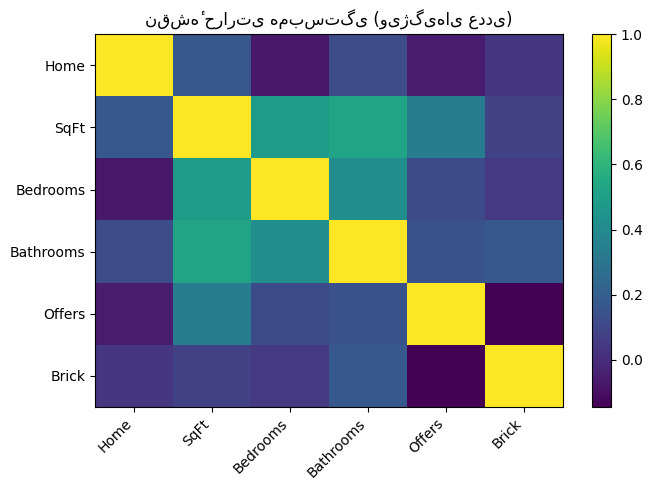

SqFt       Bathrooms    0.522745
Bathrooms  SqFt         0.522745
Bedrooms   SqFt         0.483807
SqFt       Bedrooms     0.483807
Bathrooms  Bedrooms     0.414556
Bedrooms   Bathrooms    0.414556
SqFt       Offers       0.336923
Offers     SqFt         0.336923
Bathrooms  Brick        0.171977
Brick      Bathrooms    0.171977
SqFt       Home         0.168553
Home       SqFt         0.168553
dtype: float64

In [7]:
corr = X[num_cols].corr()

plt.figure(figsize=(7, 5))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("نقشهٔ حرارتی همبستگی (ویژگی‌های عددی)")
plt.tight_layout()
plt.show()

corr_pairs(X[num_cols], top_k=12)

### VIF روی ماتریس طراحی (عددی + یک‌هات دسته‌ای)

In [8]:
X_mat, feat = build_design_matrix(X)
vif = compute_vif(X_mat, feat)
vif.head(25)

,feature,VIF
0,SqFt,1.975506
1,Offers,1.750585
2,Bedrooms,1.742065
3,Neighborhood_West,1.732270
4,Neighborhood_North,1.692545
5,Bathrooms,1.514766
6,Home,1.114580
7,Brick,1.104268


### شاخص‌های بدشرطی (ماتریس عددی استانداردشده)

In [9]:
X_num = X[num_cols].astype(float).values
X_std = StandardScaler().fit_transform(X_num)
kappa = condition_number(X_std)

XtX = X_std.T @ X_std
eigvals = np.linalg.eigvalsh(XtX)

kappa, pd.Series(eigvals).sort_values().head(10)

(2.334153408923319,
 0     49.143744
 1     67.020337
 2    101.306667
 3    130.447741
 4    152.333018
 5    267.748493
 dtype: float64)

### همبستگی‌های جزئی (ارتباط مستقیم بعد از کنترل سایرین)

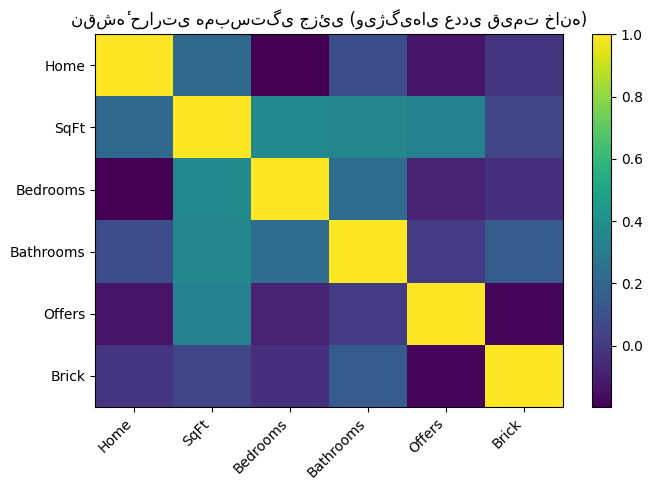

Bedrooms   SqFt         0.371326
SqFt       Bedrooms     0.371326
Bathrooms  SqFt         0.351894
SqFt       Bathrooms    0.351894
           Offers       0.330694
Offers     SqFt         0.330694
Bathrooms  Bedrooms     0.229408
Bedrooms   Bathrooms    0.229408
SqFt       Home         0.210558
Home       SqFt         0.210558
dtype: float64

In [10]:
# Partial correlation on house numeric features (after standardization)
X_num = X[num_cols].astype(float).values
X_std = StandardScaler().fit_transform(X_num)

pc = partial_corr_from_precision(X_std, num_cols)

plt.figure(figsize=(7, 5))
plt.imshow(pc.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("نقشهٔ حرارتی همبستگی جزئی (ویژگی‌های عددی قیمت خانه)")
plt.tight_layout()
plt.show()

# show strongest partial correlations (excluding diagonal)
pc_abs = pc.abs()
np.fill_diagonal(pc_abs.values, 0.0)
pairs = pc_abs.stack().sort_values(ascending=False)
pairs.head(10)

### ضرایب OLS و شکنندگی

In [11]:
X_ols = sm.add_constant(X[num_cols].astype(float))
ols = sm.OLS(y, X_ols).fit()
ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.585e+04,1.09e+04,-1.457,0.148,-3.74e+04,5683.478
Home,-10.6563,31.978,-0.333,0.740,-73.965,52.652
SqFt,59.7119,7.233,8.255,0.000,45.392,74.032
Bedrooms,9640.2640,1873.668,5.145,0.000,5930.844,1.33e+04
Bathrooms,9900.9404,2698.310,3.669,0.000,4558.924,1.52e+04
Offers,-1.222e+04,1160.636,-10.527,0.000,-1.45e+04,-9920.782
Brick,1.714e+04,2491.092,6.880,0.000,1.22e+04,2.21e+04


### پایداری بوت‌استرپ: OLS در برابر Ridge

In [12]:
Xn = X[num_cols].astype(float).values
yn = y.values.astype(float)

ols_coefs, ridge_coefs = bootstrap_coefs_linear(Xn, yn, B=400, alpha_ridge=10.0, seed=42)

coef_names = ["const"] + num_cols
ols_std = pd.Series(ols_coefs.std(axis=0), index=coef_names).sort_values(ascending=False)
ridge_std = pd.Series(ridge_coefs.std(axis=0), index=["intercept"] + num_cols).sort_values(ascending=False)

ols_std.head(10), ridge_std.head(10)

(const        11168.297361
 Brick         2878.214944
 Bathrooms     2670.266135
 Bedrooms      1717.708283
 Offers        1176.089382
 Home            33.629302
 SqFt             7.611986
 dtype: float64,
 intercept    2303.360909
 SqFt         1500.448344
 Brick        1255.677637
 Offers       1189.814804
 Bathrooms    1175.309249
 Home         1124.323070
 Bedrooms     1074.222662
 dtype: float64)

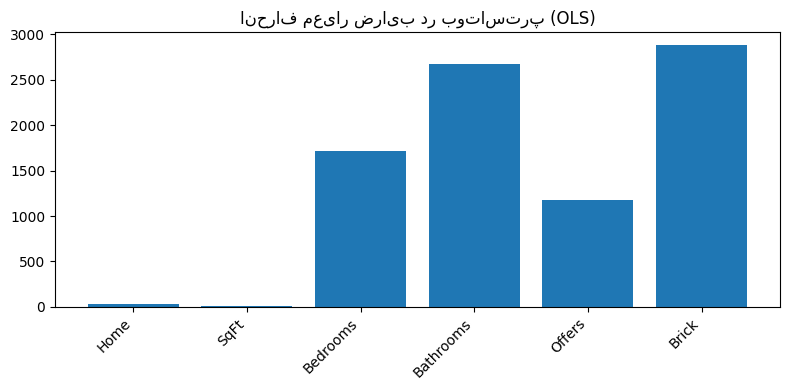

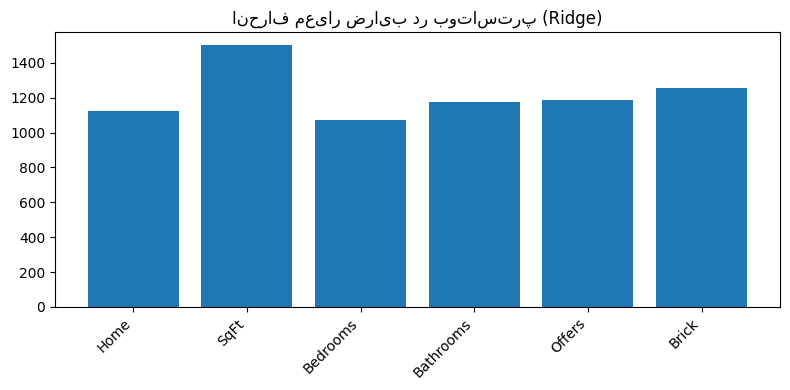

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(num_cols)), ols_std.loc[num_cols].values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.title("انحراف معیار ضرایب در بوت‌استرپ (OLS)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(len(num_cols)), ridge_std.loc[num_cols].values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.title("انحراف معیار ضرایب در بوت‌استرپ (Ridge)")
plt.tight_layout()
plt.show()

### مسیر ضرایب Ridge

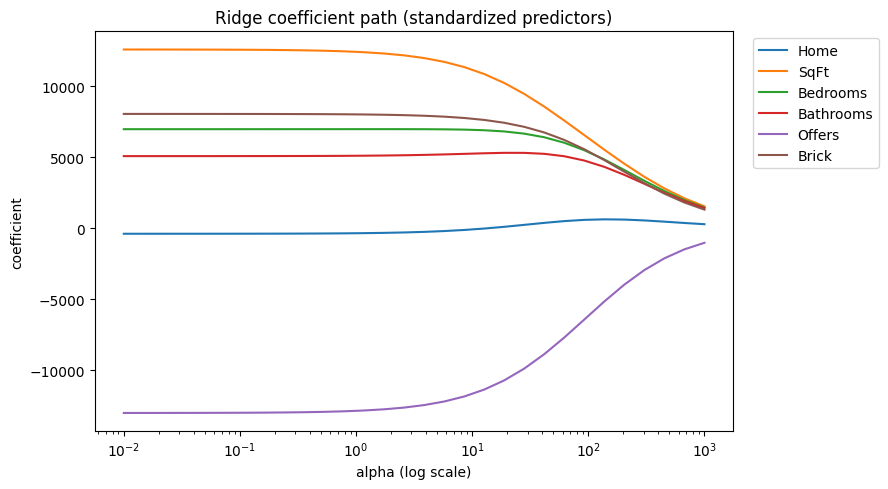

In [14]:
Xn = X[num_cols].astype(float).values
yn = y.values.astype(float)

sc = StandardScaler()
Xn_std = sc.fit_transform(Xn)

alphas = np.logspace(-2, 3, 30)
coefs = []

for a in alphas:
    m = Ridge(alpha=a)
    m.fit(Xn_std, yn)
    coefs.append(m.coef_)

coefs = np.vstack(coefs)

plt.figure(figsize=(9, 5))
for j, name in enumerate(num_cols):
    plt.plot(alphas, coefs[:, j], label=name)
plt.xscale("log")
plt.title("Ridge coefficient path (standardized predictors)")
plt.xlabel("alpha (log scale)")
plt.ylabel("coefficient")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### پایپ‌لاین PCA + Ridge

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=3))]), num_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=10.0))])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

rmse, r2

C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(9850.433457537012), 0.8417155468238763)

## ۶) دیتاست B — الماس‌ها: مخدوش‌کنندگی و تعدیل

In [16]:
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
diamonds = pd.read_csv(diamonds_path)
diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [17]:
d = diamonds.copy()

for c in ["carat", "depth", "table", "price", "x", "y", "z"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

d = d.dropna(subset=["carat", "price", "cut", "color", "clarity"])
d[["carat", "price", "cut", "color", "clarity"]].head()

,carat,price,cut,color,clarity
0,0.23,326,Ideal,E,SI2
1,0.21,326,Premium,E,SI1
2,0.23,327,Good,E,VS1
3,0.29,334,Premium,I,VS2
4,0.31,335,Good,J,SI2


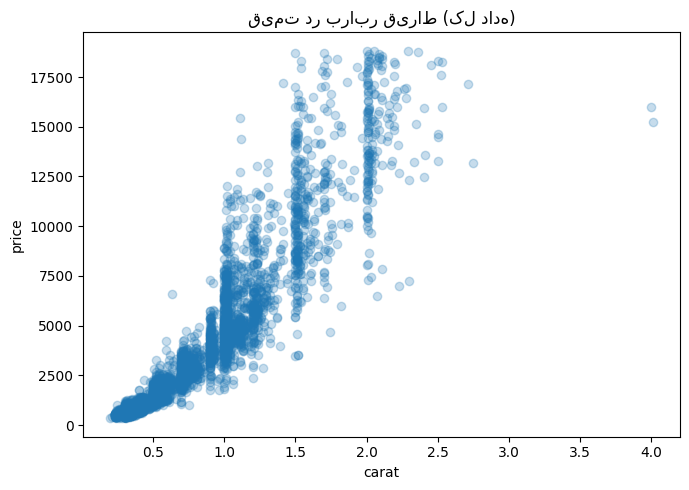

In [18]:
sample = d.sample(n=min(4000, len(d)), random_state=42)

plt.figure(figsize=(7, 5))
plt.scatter(sample["carat"], sample["price"], alpha=0.25)
plt.xlabel("carat")
plt.ylabel("price")
plt.title("قیمت در برابر قیراط (کل داده)")
plt.tight_layout()
plt.show()

In [19]:
def slope_simple(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).astype(float)
    m = LinearRegression().fit(x, y)
    return float(m.coef_[0]), float(m.intercept_), float(m.score(x, y))

overall_slope, _, overall_r2 = slope_simple(d["carat"], d["price"])

rows = []
for cut, g in d.groupby("cut"):
    s, b, r2 = slope_simple(g["carat"], g["price"])
    rows.append((cut, len(g), s, r2))

slopes = pd.DataFrame(rows, columns=["cut", "n", "slope(price~carat)", "R2"]).sort_values("n", ascending=False)

overall_slope, overall_r2, slopes.head(10)

(7756.42561796888,
 0.8493305264354858,
          cut      n  slope(price~carat)        R2
 2      Ideal  21551         8192.391304  0.867089
 3    Premium  13791         7807.752032  0.855634
 4  Very Good  12082         7935.971965  0.858162
 1       Good   4906         7479.636303  0.850954
 0       Fair   1610         5924.495106  0.738394)

### مدل تعدیل: افزودن cut/color/clarity

In [20]:
y_price = d["price"].astype(float)

XA = d[["carat"]].astype(float).values
mA = LinearRegression().fit(XA, y_price)

enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
Z = enc.fit_transform(d[["cut", "color", "clarity"]])

XB = np.column_stack([XA, Z])
mB = LinearRegression().fit(XB, y_price)

coef_A = float(mA.coef_[0])
coef_B = float(mB.coef_[0])
r2_A = mA.score(XA, y_price)
r2_B = mB.score(XB, y_price)

{"coef_A": coef_A, "coef_B": coef_B, "r2_A": r2_A, "r2_B": r2_B}

{'coef_A': 7756.42561796888,
 'coef_B': 8886.1288825037,
 'r2_A': 0.8493305264354858,
 'r2_B': 0.915940554017946}

### بررسی عدم‌تعادل (cross-tab)

In [21]:
threshold = d["carat"].median()
d2 = d.copy()
d2["T_high_carat"] = (d2["carat"] >= threshold).astype(int)

cut_tab = pd.crosstab(d2["cut"], d2["T_high_carat"], normalize="columns")
price_by_cut = d2.groupby("cut")["price"].agg(["count", "mean", "median"]).sort_values("count", ascending=False)

cut_tab, price_by_cut.head(10)

(T_high_carat         0         1
 cut                             
 Fair          0.011040  0.046316
 Good          0.071999  0.107549
 Ideal         0.497796  0.313502
 Premium       0.216155  0.290274
 Very Good     0.203010  0.242359,
            count         mean  median
 cut                                  
 Ideal      21551  3457.541970  1810.0
 Premium    13791  4584.257704  3185.0
 Very Good  12082  3981.759891  2648.0
 Good        4906  3928.864452  3050.5
 Fair        1610  4358.757764  3282.0)

## ۷) دیتاست C — دیابت: مخدوش‌کنندگی در طبقه‌بندی

In [22]:
diab_path = "../../../Datasets/Classification/diabetes.csv"
diab = pd.read_csv(diab_path)
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [23]:
dd = diab.copy()
dd["classification"] = dd["classification"].map({"Diabetic": 1, "Non-Diabetic": 0})
dd = dd.dropna()

X_d = dd.drop(columns=["classification"])
y_d = dd["classification"].astype(int)

X_d.shape, y_d.mean()

((768, 8), np.float64(0.3489583333333333))

In [24]:
tmp = dd.copy()
tmp["age_bin"] = pd.qcut(tmp["Age"], q=4, duplicates="drop")
tmp["bmi_bin"] = pd.qcut(tmp["BMI"], q=5, duplicates="drop")

rates = (
    tmp.groupby(["age_bin", "bmi_bin"])["classification"]
       .mean()
       .reset_index()
       .rename(columns={"classification": "diabetes_rate"})
)

rates.head()

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27872\161782832.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby(["age_bin", "bmi_bin"])["classification"]


,age_bin,bmi_bin,diabetes_rate
0,"(20.999, 24.0]","(-0.001, 25.9]",0.029851
1,"(20.999, 24.0]","(25.9, 30.1]",0.041667
2,"(20.999, 24.0]","(30.1, 33.7]",0.195122
3,"(20.999, 24.0]","(33.7, 37.8]",0.241379
4,"(20.999, 24.0]","(37.8, 67.1]",0.352941


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27872\3686286024.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for age_bin, g in rates.groupby("age_bin"):


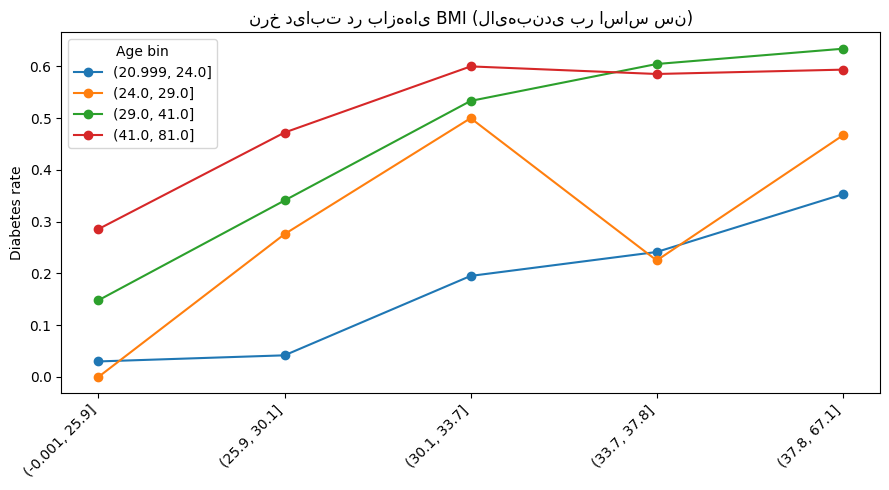

In [25]:
plt.figure(figsize=(9, 5))

for age_bin, g in rates.groupby("age_bin"):
    xs = np.arange(len(g["bmi_bin"]))
    plt.plot(xs, g["diabetes_rate"].values, marker="o", label=str(age_bin))

plt.xticks(xs, [str(b) for b in sorted(rates["bmi_bin"].unique())], rotation=45, ha="right")
plt.ylabel("Diabetes rate")
plt.title("نرخ دیابت در بازه‌های BMI (لایه‌بندی بر اساس سن)")
plt.legend(title="Age bin")
plt.tight_layout()
plt.show()

### لجستیک: مدل ساده در برابر مدل تعدیل‌شده (AUC)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_d, y_d, test_size=0.25, random_state=42, stratify=y_d)

def fit_logit_and_auc(cols):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs", C=1.0))
    ])
    pipe.fit(X_train[cols], y_train)
    proba = pipe.predict_proba(X_test[cols])[:, 1]
    auc = roc_auc_score(y_test, proba)
    coef = pd.Series(pipe.named_steps["clf"].coef_[0], index=cols)
    return auc, coef

auc_bmi, coef_bmi = fit_logit_and_auc(["BMI"])
auc_adj, coef_adj = fit_logit_and_auc(["BMI", "Age", "Glucose"])

auc_bmi, auc_adj, coef_bmi, coef_adj

(np.float64(0.6885373134328359),
 np.float64(0.8081194029850746),
 BMI    0.743968
 dtype: float64,
 BMI        0.673318
 Age        0.329945
 Glucose    1.059400
 dtype: float64)

### غربال‌گری هم‌خطی بین پیش‌بین‌ها (VIF)

In [27]:
Xd = X_d.astype(float).values
feat = X_d.columns.tolist()
Xd_std = StandardScaler().fit_transform(Xd)
compute_vif(Xd_std, feat).head(15)

,feature,VIF
0,Age,1.588368
1,SkinThickness,1.507432
2,Pregnancies,1.430872
3,Insulin,1.427536
4,Glucose,1.298961
5,BMI,1.297450
6,BloodPressure,1.181863
7,DiabetesPedigreeFunction,1.067090


### رزیدوال‌سازی (تشخیصی)

In [28]:
# Residualization: remove age-related variation from BMI, then assess patterns
tmp = dd[["BMI", "Age", "classification"]].dropna().copy()
X_age = sm.add_constant(tmp["Age"].astype(float))
m = sm.OLS(tmp["BMI"].astype(float), X_age).fit()
tmp["BMI_resid"] = m.resid

# Compare logistic regression on BMI vs BMI_resid
X_train, X_test, y_train, y_test = train_test_split(tmp[["BMI", "BMI_resid", "Age"]], tmp["classification"].astype(int),
                                                    test_size=0.25, random_state=42, stratify=tmp["classification"])

def auc_for(col):
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))])
    pipe.fit(X_train[[col]], y_train)
    p = pipe.predict_proba(X_test[[col]])[:, 1]
    return roc_auc_score(y_test, p)

{"AUC_BMI": auc_for("BMI"), "AUC_BMI_resid": auc_for("BMI_resid"), "AUC_Age": auc_for("Age")}

{'AUC_BMI': np.float64(0.6885373134328359),
 'AUC_BMI_resid': np.float64(0.6844776119402985),
 'AUC_Age': np.float64(0.7037014925373135)}

## ۱۰) نکات تفسیری (قبل از نتیجه‌گیری بخوانید)

### ۱۰.۱ چندهمخطی «خطای داده» نیست
چندهمخطی یک ویژگی هندسیِ فضای ویژگی‌هاست. در بسیاری از دامنه‌های واقعی، اندازه‌گیری‌ها ذاتاً همبسته‌اند: معیارهای اندازه، جمع‌ها و اجزای آن‌ها، شاخص‌های اقتصادی، نشانگرهای بالینی و غیره. هدف EDA «حذف همهٔ همبستگی‌ها» نیست؛ هدف این است که بفهمیم کجا افزونگی، تفسیر را شکننده یا محاسبات را ناپایدار می‌کند.

### ۱۰.۲ با منظم‌سازی چه چیزی تغییر می‌کند؟
Ridge تابع هدف را طوری تغییر می‌دهد که راه‌حل‌ها در جهت‌هایی که به‌خوبی شناسایی نشده‌اند کوچک شوند. در بیان SVD، جهت‌هایی با مقدار تکین کوچک همان‌هایی هستند که در OLS به‌وسیلهٔ $(X^T X)^{-1}$ بزرگ‌نمایی می‌شوند؛ Ridge اثر آن‌ها را کم می‌کند. به همین دلیل Ridge معمولاً پروفایل ضرایب هموارتر و پایدارتر می‌دهد. لاسو برای پراکندگی مفید است، اما بین ویژگی‌های همبسته ممکن است یکی را دلخواه انتخاب کند و شما آن را به شکل ناپایداری بین تقسیم‌های مختلف مشاهده می‌کنید.

### ۱۰.۳ مخدوش‌کنندگی مسئلهٔ طراحی است نه مسئلهٔ یک معیار
مخدوش‌کنندگی را نمی‌توان با یک عدد «رفع» کرد. سؤال درست این است: «داده‌ها چگونه تولید شده‌اند و چه متغیرهایی اندازه‌گیری شده‌اند؟» در داده‌های مشاهده‌ای، مخدوش‌کنندگی حالت پیش‌فرض است. بنابراین EDA باید از لایه‌بندی، مدل‌های تعدیل و بررسی منشأ ویژگی‌ها استفاده کند تا داستان‌سازی صرفاً بر اساس همبستگیِ تجمیع‌شده رخ ندهد.

### ۱۰.۴ زبان علّی نیازمند شناسایی است
حتی بعد از تعدیل، یک ضریب خودبه‌خود علّی نمی‌شود. ادعای علّی نیازمند استراتژی شناسایی است (تصادفی‌سازی، ابزارها، آزمایش‌های طبیعی یا گراف علّی توجیه‌شده). در آموزش ML، تمرین کنید که زبان دقیق به کار ببرید: «همراه با» یا «مرتبط با» به جای «سبب می‌شود».

### ۱۰.۵ الگوی گزارش‌دهی عملی
در ارائهٔ نتایج این درس، این موارد را بیاورید: (۱) غربال‌گری همبستگی، (۲) VIF/بدشرطی، (۳) آزمون پایداری، (۴) مقایسهٔ قبل/بعدِ کاهش اثر، و (۵) یک یادداشت کوتاه دربارهٔ اینکه داده‌ها چه چیزی را پشتیبانی می‌کنند و چه چیزی را نه.

## ۱۱) خطاهای رایج (از این‌ها پرهیز کنید)
- فقط ماتریس همبستگی را گزارش کردن و اگر همبستگی‌ها زیر ۰٫۸ بود ادعا کردن که چندهمخطی «حل شد».
- VIF را روی ستون‌های خام محاسبه کردن ولی مدل را روی ماتریس طراحیِ مهندسی‌شده/کدگذاری‌شده آموزش دادن.
- وقتی چند جایگزین همبسته وجود دارد، ویژگی‌های انتخاب‌شده توسط لاسو را به‌صورت یکتای مهم تفسیر کردن.
- بدون استانداردسازی، بزرگیِ ضریب را به‌عنوان اهمیت ویژگی تفسیر کردن.
- جمله‌های چندجمله‌ای ($x$ و $x^2$) را بدون مرکزسازی اضافه کردن و بعد از VIFهای بزرگ تعجب کردن.
- برای یک برخوردگر (متغیری که از مواجهه و خروجی اثر می‌گیرد) تعدیل انجام دادن و ارتباط کاذب ساختن.
- برای متغیرهای پس از رخداد تعدیل انجام دادن (نشت داده با ظاهر علّی).
- بدون بررسی پایداری در تقسیم‌های مختلف، فقط با دادهٔ آموزش تصمیم گرفتن کدام متغیر همبسته حذف شود.
- فرض کردن که افزایش $R^2$ بعد از افزودن کنترل‌ها نشان‌دهندهٔ علیت است.
- برای «کنترل مخدوش‌کنندگی» فقط از میانگین‌های گروهی استفاده کردن و تغییرات درون‌گروهی را نادیده گرفتن.
- فراموش کردن اینکه یک‌هات با همهٔ سطوح هم‌خطی کامل ایجاد می‌کند (دام دامی).
- واحدها/مقیاس‌ها را قاطی کردن (مثلاً دلار و فوت مربع) و ضریب‌ها را مستقیم مقایسه کردن.
- تکیه بر یک شاخص واحد (فقط VIF یا فقط عدد شرط).
- به‌خاطر معنی‌داری ضریب تعدیل‌شده ادعا کردن «مخدوش‌کنندگی نداریم»؛ معنی‌داری شناسایی علّی نیست.
- نادیده گرفتن قیود دامنه: حذف متغیری که برای انصاف/ممیزی ضروری است.

## ۱۲) یک گزارش EDA قوی شامل چیست؟
- هم نمای غربال‌گری (همبستگی) و هم نمای مدل‌محور (VIF روی ماتریس طراحی) را گزارش کنید.
- عدد شرط را روی ماتریس عددیِ استانداردشده گزارش کنید و روش استانداردسازی را ذکر کنید.
- اگر ضرایب را تفسیر می‌کنید، پایداری را با تقسیم‌های تکراری یا بوت‌استرپ نشان دهید.
- اگر ویژگی حذف می‌کنید، با قواعد حاکمیت ویژگی توجیه کنید (تکرار، دسترس‌پذیری، نشت، انصاف).
- برای مخدوش‌کنندگی، خلاصه‌های لایه‌بندی‌شده و سپس مدل تعدیل‌شده را نشان دهید؛ ضرایب کلیدی را مقایسه کنید.
- ادعاهای پیش‌بینی («AUC/RMSE بهتر») را از ادعاهای علّی («سبب می‌شود») جدا کنید.
- ثبت کنید چه متغیرهایی در زمان پیش‌بینی در دسترس‌اند؛ مخدوش‌کننده‌های ناموجود در زمان اجرا قابل استفاده نیستند.
- در استفاده از PCA، واریانس تبیین‌شده و بارگذاری‌ها را گزارش کنید تا زمینهٔ تفسیر حفظ شود.
- در منظم‌سازی، پارامتر انتخابی و روش انتخاب آن را گزارش کنید.
- خطر پروکسی را علامت‌گذاری کنید: یک ویژگی می‌تواند پروکسیِ صفت حساس باشد حتی اگر آن صفت حذف شده باشد.

## ۱۳) شاخص‌های پیشرفته‌ای که می‌توانید اضافه کنید
- همبستگی جزئی (با ماتریس دقت) به کشف ارتباط‌های مستقیم بعد از کنترل سایر پیش‌بین‌ها کمک می‌کند.
- دید تجزیهٔ واریانس: مقدارهای ویژهٔ کوچک جهت‌هایی را نشان می‌دهند که ماتریس طراحی تقریباً افزونه است.
- مدل‌سازی گروه‌به‌گروه: یک مدل را در هر لایه برازش دهید تا ببینید رابطه‌ها پایدار می‌مانند یا نه.
- رزیدوال‌سازی ابزار تشخیصی است: تغییرات توضیح‌داده‌شده توسط مخدوش‌کنندهٔ مشکوک را حذف کنید و الگوها را دوباره بسنجید.
- چندهمخطی شدید می‌تواند اهمیتِ جابه‌جایی را ناپایدار کند؛ اهمیت گروهی یا روش‌های شرطی را ترجیح دهید.
- در مخدوش‌کنندگی دسته‌ای، جدول‌های عدم‌تعادل (cross-tab) اغلب از همبستگی‌ها اطلاعاتی‌ترند.
- برای ویژگی‌های وابسته به زمان، مخدوش‌کنندگی می‌تواند با انتخاب ایجاد شود؛ ترتیب زمانی را صریح رعایت کنید.
- همه‌چیز را «کنترل» نکنید: فقط متغیرهایی را وارد کنید که با سؤال و منشأ ویژگی توجیه می‌شوند.


## ۱۴) تمرین‌ها

1. در house-prices، VIF و پایداری را بعد از حذف **Bedrooms** در برابر حذف **SqFt** مقایسه کنید.
2. در diamonds، کنترل‌های تعدیل را گسترش دهید و تغییر ضریب قیراط را بررسی کنید.
3. در diabetes، قدرت منظم‌سازی را با تغییر `C` تنظیم کنید و کوچک‌شدن ضرایب را ببینید.
4. یک وابستگی خطی نزدیک بسازید و واکنش شاخص‌ها را بررسی کنید.
5. یک یادداشت EDA بنویسید که نتیجه‌های پیش‌بینی را از زبان علّی جدا کند.
